In [57]:
import subprocess
import sys
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from typing import Tuple, Iterator
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree
from bids import BIDSLayout
from util.io.iter_BIDSPaths import *
from mne.time_frequency import stft

In [58]:
BIDS_ROOT = '../data/bids'
WSIZE = 200

In [59]:
layout = BIDSLayout(BIDS_ROOT, derivatives = True)
fpaths = layout.get(scope = 'preprocessing',
                    res = 'hi',
                    suffix='epo',
                    extension = 'fif.gz',
                    return_type = 'filename')

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


In [60]:
# for (fpaths, sub, task, run) in iter_BIDSPaths(fpaths):
#     print(sub)
epochs = mne.read_epochs(fpaths[0])

Reading /project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocessing/sub-2/sub-2_task-pitch_run-1_res-hi_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -200.00 ...     250.00 ms
        0 CTF compensation matrices available
Reading /project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocessing/sub-2/sub-2_task-pitch_run-1_desc-clean_5khz_epo.fif-1.gz ...
    Found the data of interest:
        t =    -200.00 ...     250.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
0 bad epochs dropped
Not setting metadata
4553 matching events found
No baseline correction applied
0 projection items activated


In [16]:
# power = stft(epochs,
#             wsize = WSIZE)

# np.size(epochs.get_data())
# epochs_100 = epochs['100'].get_data()

    Using multitaper spectrum estimation with 7 DPSS windows


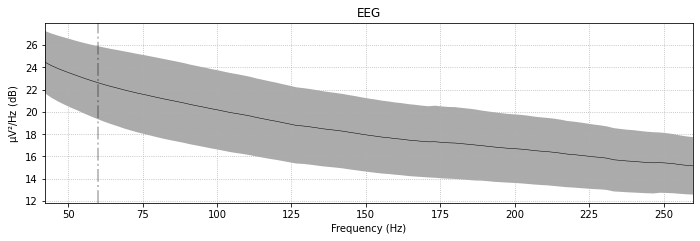

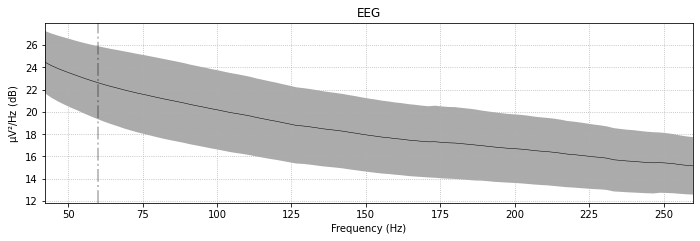

In [25]:
# epochs.plot_psd(fmin=40, fmax=260., average=True, spatial_colors=False)

    Using multitaper spectrum estimation with 7 DPSS windows


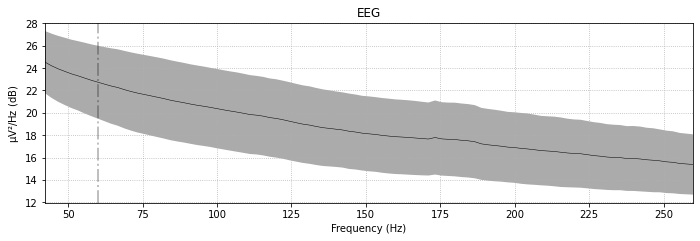

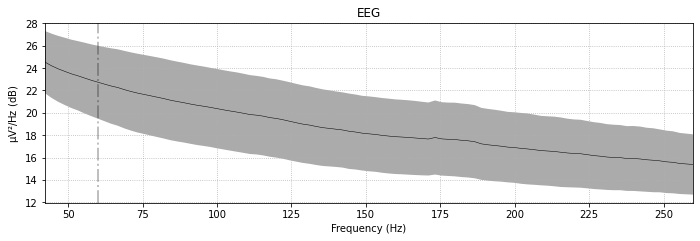

In [61]:
epochs_100hz = epochs.get_data(item = '100')
epochs['100'].plot_psd(fmin=40, fmax=260., average=True, spatial_colors=False)

In [29]:
power = stft(epochs_100hz[1],
     wsize = WSIZE,
     tstep = WSIZE/2)


Number of frequencies: 101
Number of time steps: 23


In [32]:
np.shape(power)

(62, 101, 23)

In [36]:
gfp = np.mean(power, axis = 0)
np.shape(gfp)

(101, 23)

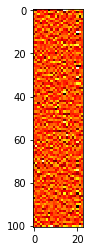

In [42]:
gfp.real
plt.imshow(gfp.real, cmap='hot', interpolation='nearest')

In [52]:
np.shape(epochs_100hz[0, 0])

(2251,)

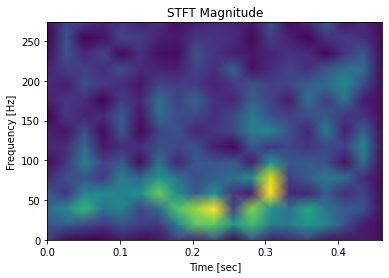

In [87]:
fs = 5000
x = epochs_100hz[1, 0]

f, t, Zxx = signal.stft(x, fs)

# Trim to frequencies < 300 Hz
i = int(np.argwhere(f < 300)[-1])
f = f[0:i]
Zxx = Zxx[0:i,]

plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [67]:
np.shape(np.abs(Zxx))
# np.shape(f)

(129, 19)

In [85]:
int(i)

15